# Predicting Blood Ethanol Content (BEC) through volume of ethanol consumed

## Load data

In [ ]:
# Mount Google Drive and Load Data

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# File paths (adjust if your folder structure is different)
mtd_path = '/content/drive/MyDrive/mtd_DataAcrossCohortsApr17.csv'
ebt_path = '/content/drive/MyDrive/ExpBout_DataAcrossCohortsApr17.csv'
meta_path = '/content/drive/MyDrive/MonkeyDataAcrossCohortsCapstoneDR.csv'
new_time_series = '/content/drive/MyDrive/new_timeseries.csv'

# Load CSVs
mtd_df = pd.read_csv(mtd_path)
ebt_df = pd.read_csv(ebt_path)
monkey_meta_df = pd.read_csv(meta_path)
new_time_series = pd.read_csv(new_time_series)


# Preview each
#mtd_df.head()
#ebt_df.head()
#monkey_meta_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Clean and align date columns

### NOTE: used the bout data to find out start time/date and aligned that with BEC recordings timeframe

In [ ]:
# Recalculate first bout date per monkey
start_dates = (
    ebt_df.groupby('mky_id')['date']
    .min()
    .reset_index()
)
start_dates.columns = ['mky_id', 'first_bout_date']
start_dates['first_bout_date'] = pd.to_datetime(start_dates['first_bout_date'], errors='coerce')  # enforce datetime

# STEP 2: Ensure ID column types match across all dataframes
mtd_df['mky_id'] = mtd_df['mky_id'].astype(int)
ebt_df['mky_id'] = ebt_df['mky_id'].astype(int)
monkey_meta_df['mky_id'] = monkey_meta_df['mky_id'].astype(int)

# STEP 3: Merge first_bout_date into monkey metadata
monkey_meta_df = monkey_meta_df.merge(start_dates, on='mky_id', how='left')

# STEP 4: Convert BEC experiment day to numeric
monkey_meta_df['bec_exper_day'] = pd.to_numeric(monkey_meta_df['bec_exper_day'], errors='coerce')

# STEP 5: Convert merged first_bout_date to datetime again (in case it became object in merge)
monkey_meta_df['first_bout_date'] = pd.to_datetime(monkey_meta_df['first_bout_date'], errors='coerce')

# STEP 6: Compute calendar-aligned date for BEC sample
monkey_meta_df['bec_aligned_date'] = monkey_meta_df['first_bout_date'] + pd.to_timedelta(
    monkey_meta_df['bec_exper_day'], unit='D'
)

# STEP 7: Convert and extract BEC sample hour as float
monkey_meta_df['bec_sample'] = pd.to_datetime(monkey_meta_df['bec_sample'], errors='coerce')
monkey_meta_df['bec_sample_hour'] = monkey_meta_df['bec_sample'].dt.hour + (
    monkey_meta_df['bec_sample'].dt.minute / 60
)

# Preview key output columns
monkey_meta_df[['mky_id', 'first_bout_date', 'bec_exper_day', 'bec_aligned_date', 'bec_sample_hour', 'bec_mg_pct']].dropna().head()


<ipython-input-11-17b3a380db66>:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monkey_meta_df['bec_sample'] = pd.to_datetime(monkey_meta_df['bec_sample'], errors='coerce')


,mky_id,first_bout_date,bec_exper_day,bec_aligned_date,bec_sample_hour,bec_mg_pct
0,10005,2003-08-21,24.0,2003-09-14,11.766667,15.0
1,10005,2003-08-21,24.0,2003-09-14,11.766667,15.0
2,10005,2003-08-21,24.0,2003-09-14,11.766667,15.0
3,10005,2003-08-21,24.0,2003-09-14,11.766667,15.0
4,10005,2003-08-21,24.0,2003-09-14,11.766667,15.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class BEC_Simulator:
    def __init__(self, Vd=0.6, elimination_rate_mgdl_per_hr=20, absorption_minutes=30):
        """
        Vd: Volume of distribution (L/kg)
        elimination_rate_mgdl_per_hr: Max elimination rate (mg/dL/hr), assumed linear
        absorption_minutes: Duration over which ethanol is absorbed (in minutes)
        """
        self.Vd = Vd
        self.elim_rate_per_sec = elimination_rate_mgdl_per_hr / 3600  # mg/dL per sec
        self.absorption_window = absorption_minutes * 60  # seconds

    def _compute_absorption(self, bouts_df, monkey_weight_kg, total_time_sec):
        """
        Builds an absorption timeline based on ethanol intake bouts.
        """
        ethanol_density = 0.789  # g/mL
        ethanol_conc = 0.04      # 4% ethanol
        absorption_timeline = np.zeros(total_time_sec + 1)

        for _, bout in bouts_df.iterrows():
            if pd.isna(bout['ebt_start_time']) or pd.isna(bout['ebt_volume']):
                continue

            start = int(bout['ebt_start_time'])
            if start >= total_time_sec:
                continue

            vol = bout['ebt_volume'] / 1000  # L
            dose_g = vol * ethanol_conc * ethanol_density  # g of ethanol
            bec_peak = (dose_g * 1000) / (monkey_weight_kg * self.Vd)  # mg/dL

            # Spread dose over absorption window (triangular shape)
            for i in range(self.absorption_window):
                t = start + i
                if t >= total_time_sec:
                    break
                factor = 1 - abs(i - self.absorption_window/2) / (self.absorption_window/2)
                absorption_timeline[t] += bec_peak * factor / self.absorption_window

        return absorption_timeline

    def _apply_elimination(self, absorption_timeline):
        """
        Applies linear metabolic decay to the absorption timeline.
        """
        bec_timeline = np.zeros_like(absorption_timeline)
        elimination_timeline = np.zeros_like(absorption_timeline)
        current_bec = 0

        for t in range(len(absorption_timeline)):
            current_bec += absorption_timeline[t]
            eliminated = min(current_bec, self.elim_rate_per_sec)
            current_bec -= eliminated
            elimination_timeline[t] = eliminated
            bec_timeline[t] = current_bec

        return bec_timeline, absorption_timeline, elimination_timeline

    def simulate_bec(self, bouts_df, monkey_weight_kg, total_time_sec=79200):
        """
        Simulate BEC timeline over a session.
        """
        absorption = self._compute_absorption(bouts_df, monkey_weight_kg, total_time_sec)
        bec_timeline, absorption_timeline, elimination_timeline = self._apply_elimination(absorption)

        # Optional: warning for extreme values
        if np.max(bec_timeline) > 300:
            print("WARNING: Simulated BEC exceeds 300 mg/dL. Check model inputs.")

        # Package results into a dictionary if you want further analysis
        return {
            "bec": bec_timeline,
            "absorption": absorption_timeline,
            "elimination": elimination_timeline
        }

    def plot_bec(self, timeline_dict):
        """
        Plot BEC curve with optional absorption and elimination overlays.
        """
        bec = timeline_dict["bec"]
        absorption = timeline_dict["absorption"]
        elimination = timeline_dict["elimination"]
        time_hours = np.arange(len(bec)) / 3600

        plt.figure(figsize=(14, 6))
        plt.plot(time_hours, bec, label="BEC (mg/dL)", linewidth=2)
        plt.plot(time_hours, absorption, alpha=0.4, label="Absorption", linestyle='dotted')
        plt.plot(time_hours, elimination, alpha=0.4, label="Elimination", linestyle='dashed')
        #plt.axhline(y=80, color='red', linestyle='--', label='Human Binge Threshold (80 mg/dL)')
        plt.title("Simulated Blood Ethanol Concentration (BEC)")
        plt.xlabel("Time (hours)")
        plt.ylabel("BEC (mg/dL)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
def select_monkey_session(ebt_df, monkey_meta_df):
    # Only include monkeys with known weight
    valid_weights = monkey_meta_df.dropna(subset=['mky_weight'])
    valid_ids = valid_weights['mky_id'].unique()

    # Filter EBT to only those monkeys
    ebt_filtered = ebt_df[ebt_df['mky_id'].isin(valid_ids)]

    # Display only valid monkeys
    monkeys = ebt_filtered['mky_id'].unique()
    print("Available Monkeys (with weight):", monkeys)

    monkey_id = int(input("Enter a Monkey ID: "))

    # Show dates available for this monkey
    dates = ebt_filtered[ebt_filtered['mky_id'] == monkey_id]['date'].dropna().unique()
    dates = pd.to_datetime(dates)
    dates = np.sort(dates)

    print(f"\nAvailable Dates for Monkey {monkey_id}:")
    for i, d in enumerate(dates):
      print(f"{i}: {pd.to_datetime(d).date()}")

    idx = int(input("Pick a date index: "))
    session_date = dates[idx]

    return monkey_id, session_date


In [ ]:
ebt_df['date'] = pd.to_datetime(ebt_df['date'], errors='coerce')


Available Monkeys (with weight): [10005 10006 10007 10008 10010 10011 10012 10013 10014 10015 10016 10018
 10019 10020 10021 10022 10023 10024 10025 10026 10027 10032 10033 10035
 10036 10038 10039 10040 10041 10042 10044 10045 10048 10049 10051 10052
 10054 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065
 10066 10067 10069 10070 10072 10073 10074 10075 10077 10078 10079 10080
 10081 10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10092
 10097 10098 10099 10102 10104 10208 10209 10210 10211 10212 10213 10214
 10215 10242 10243 10244 10246 10247 10248 10249 10251 10252]
Enter a Monkey ID: 10005

Available Dates for Monkey 10005:
0: 2003-08-21
1: 2003-08-22
2: 2003-08-24
3: 2003-08-25
4: 2003-08-26
5: 2003-08-27
6: 2003-08-28
7: 2003-08-29
8: 2003-08-30
9: 2003-08-31
10: 2003-09-01
11: 2003-09-02
12: 2003-09-03
13: 2003-09-04
14: 2003-09-05
15: 2003-09-06
16: 2003-09-07
17: 2003-09-08
18: 2003-09-09
19: 2003-09-10
20: 2003-09-11
21: 2003-09-12
22: 2003-09-13

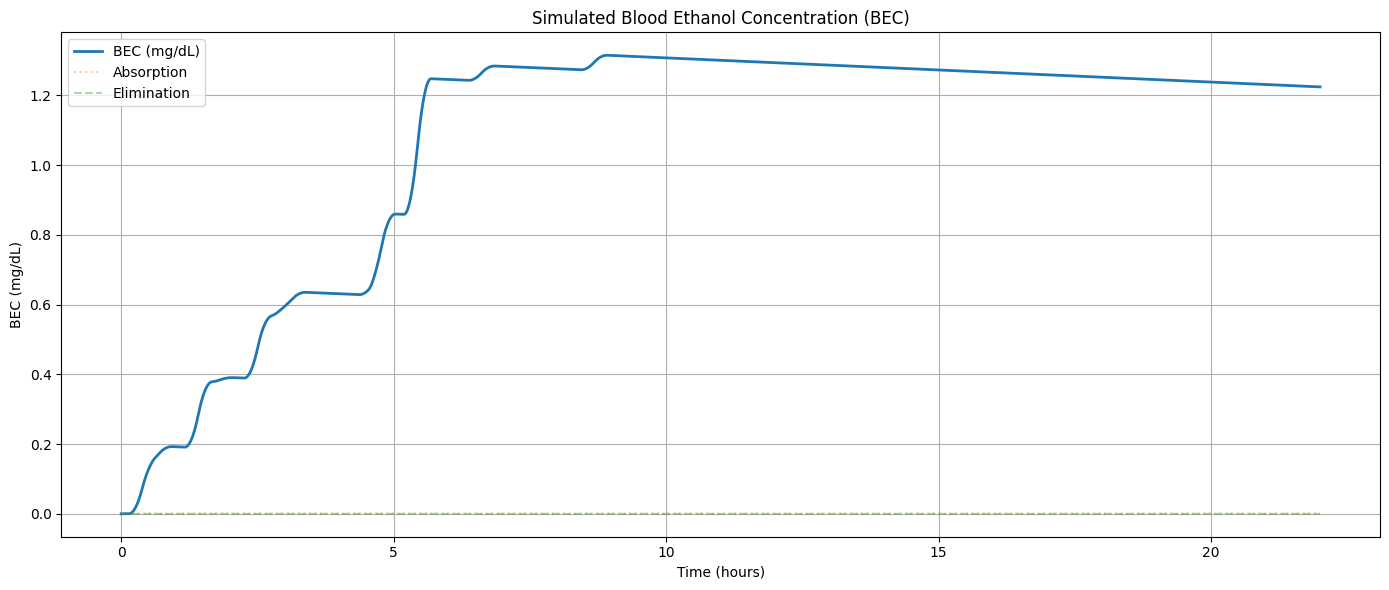

In [ ]:
#Select a monkey and date
monkey_id, session_date = select_monkey_session(ebt_df, monkey_meta_df)

# Filter bouts
bouts = ebt_df[
    (ebt_df['mky_id'] == monkey_id) &
    (ebt_df['date'] == session_date)
]

# Get monkey weight
weight_row = monkey_meta_df[monkey_meta_df['mky_id'] == monkey_id]
if weight_row.empty:
    raise ValueError("No weight found for selected monkey.")
monkey_weight = weight_row['mky_weight'].iloc[0]

#Choose species-specific elimination rate
cohort = weight_row['cohort_name'].iloc[0].lower() # Access cohort name and convert to lowercase for comparison

if "cyno" in cohort:
    elimination_rate = 0.00694  # Cynomolgus 25 mg/dL/hr / 3600 since we are dealing with second data
else:
    elimination_rate = 0.00417  # Rhesus 15 mg/dL/hr / 3600


# Step 5: Simulate
simulator = BEC_Simulator(Vd=0.6, elimination_rate_mgdl_per_hr=elimination_rate)
bec = simulator.simulate_bec(bouts, monkey_weight)

# Step 6: Plot
simulator.plot_bec(bec)


# Create function for data export

In [ ]:
import os

def generate_bec_simulation_dataset(
    ebt_df, monkey_meta_df, simulator_class, output_csv_path="/content/BEC_simulation_all_monkeys.csv",
    total_time_sec=79200, time_interval_sec=300  # 5-minute intervals
):
    all_results = []

    # Filter valid monkeys with known weight
    valid_monkeys = monkey_meta_df.dropna(subset=['mky_weight'])['mky_id'].unique()
    print(f"Total valid monkeys with weight: {len(valid_monkeys)}")

    for monkey_id in valid_monkeys:
        weight_row = monkey_meta_df[monkey_meta_df['mky_id'] == monkey_id]
        monkey_weight = weight_row['mky_weight'].iloc[0]
        cohort = str(weight_row['cohort_name'].iloc[0]).lower()
        sex = weight_row['mky_gender'].iloc[0] if 'mky_gender' in weight_row.columns else None
        species = weight_row['species'].iloc[0] if 'species' in weight_row.columns else None

        # Assign correct elimination rate
        if "cyno" in cohort:
            elimination_rate = 0.00694  # Cyno
        else:
            elimination_rate = 0.00417  # Rhesus

        # Filter EBT for this monkey
        monkey_bouts = ebt_df[ebt_df['mky_id'] == monkey_id]
        session_dates = pd.to_datetime(monkey_bouts['date'].dropna().unique())
        session_dates = np.sort(session_dates)

        for session_date in session_dates:
            bouts = monkey_bouts[monkey_bouts['date'] == session_date]
            if bouts.empty:
                continue

            # Simulate
            simulator = simulator_class(Vd=0.6, elimination_rate_mgdl_per_hr=elimination_rate)
            timeline = simulator.simulate_bec(bouts, monkey_weight, total_time_sec=total_time_sec)

            # Downsample to every N seconds
            step = time_interval_sec
            time_idx = np.arange(0, total_time_sec + 1, step)

            hours = time_idx / 3600

            for t in time_idx:
                all_results.append({
                    'mky_id': monkey_id,
                    'date': pd.to_datetime(session_date).date(),
                    'cohort': cohort,
                    'sex': sex,
                    'species': species,
                    'weight': monkey_weight,
                    'time_sec': t,
                    'time_hr': t / 3600,
                    'BEC': timeline['bec'][t],
                    'Absorption': timeline['absorption'][t],
                    'Elimination': timeline['elimination'][t]
                })

    # Create DataFrame and export
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"Dataset saved to: {output_csv_path}")


In [ ]:
generate_bec_simulation_dataset(
    ebt_df=ebt_df,
    monkey_meta_df=monkey_meta_df,
    simulator_class=BEC_Simulator,
    output_csv_path="/content/BEC_simulation_all_monkeys.csv",
    total_time_sec=79200,
    time_interval_sec=300  # 5 minutes
)


Total valid monkeys with weight: 102


In [ ]:
from google.colab import files
files.download("/content/BEC_simulation_all_monkeys.csv")

### Future work
From MATRR, gather data of sustance consumed and the weight change of each monkey over time and update model.



# Work using the new time series

In [ ]:
bouts_df = new_time_series.rename(columns={
    'bin_start_s': 'ebt_start_time',
    'volume': 'ebt_volume'
})

bouts_df = bouts_df[['mky_id', 'date', 'ebt_start_time', 'ebt_volume']]
bouts_df['date'] = pd.to_datetime(bouts_df['date'], errors='coerce')

Test our previous functions with the new data

Available Monkeys (with weight): [10005 10006 10007 10008 10010 10011 10012 10013 10014 10015 10016 10018
 10019 10020 10021 10022 10023 10024 10025 10026 10027 10032 10035 10036
 10038 10039 10040 10041 10042 10044 10045 10048 10049 10051 10052 10054
 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065 10066
 10067 10069 10070 10072 10073 10074 10075 10077 10078 10079 10080 10081
 10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10092 10097
 10098 10099 10102 10104 10208 10209 10210 10211 10212 10213 10214 10215
 10242 10243 10244 10246 10247 10248 10249 10251 10252 10254 10255 10256
 10257 10258 10259 10260 10261 10262 10263 10264 10265 10319 10320 10321
 10322 10323 10324 10325 10326 10327 10328 10329 10330 10331 10332 10333
 10334 10335 10336 10337 10338 10339 10340 10341 10342 10352 10353 10354
 10355 10356 10357 10358 10359]
Enter a Monkey ID: 10005

Available Dates for Monkey 10005:
0: 2003-08-21
1: 2003-08-22
2: 2003-08-24
3: 2003-08-25
4: 2003-08-26
5:

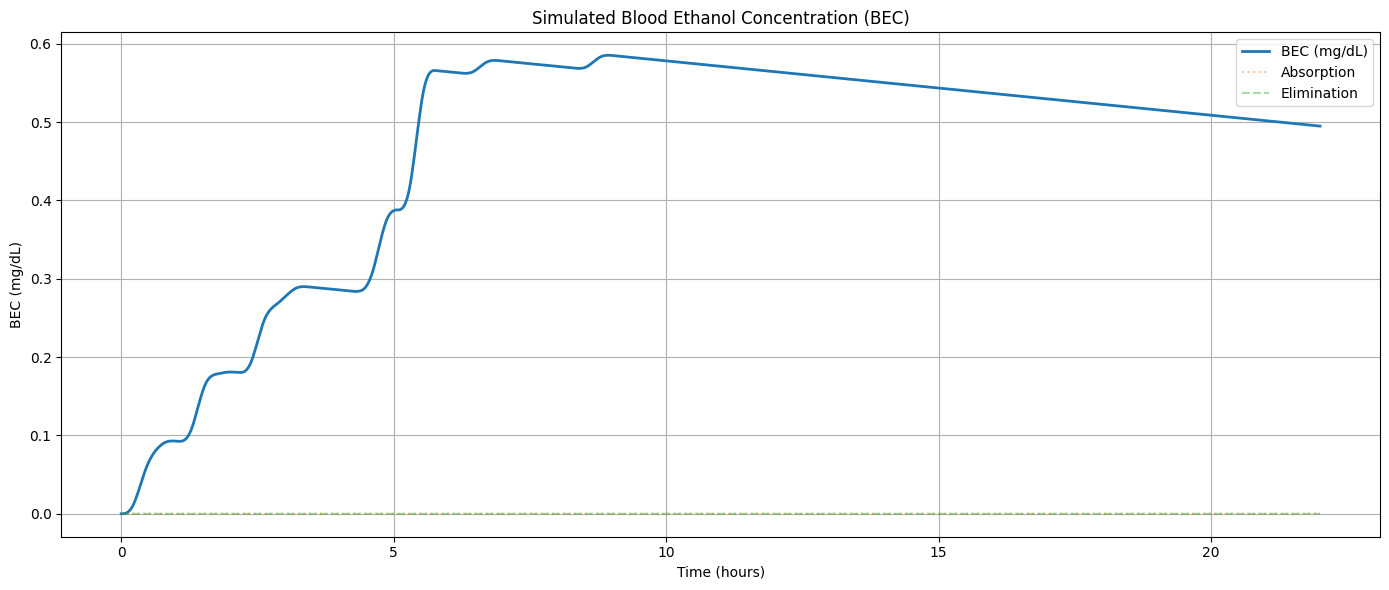

In [ ]:
# Select a monkey/date
new_monkey_id, new_session_date = select_monkey_session(bouts_df, monkey_meta_df)

# Filter bouts for that monkey + date
new_bouts = bouts_df[(bouts_df['mky_id'] == new_monkey_id) & (bouts_df['date'] == new_session_date)]


# Get monkey weight and cohort
meta = monkey_meta_df[monkey_meta_df['mky_id'] == new_monkey_id]
if meta.empty:
    raise ValueError("No weight found for selected monkey.")
monkey_weight = meta['mky_weight'].iloc[0]
cohort = meta['cohort_name'].iloc[0].lower()

# Set correct elimination rate
elimination_rate = 0.00694 if "cyno" in cohort else 0.00417

# Simulate
simulator = BEC_Simulator(Vd=0.6, elimination_rate_mgdl_per_hr=elimination_rate)
bec_timeline = simulator.simulate_bec(new_bouts, monkey_weight)

# Plot
simulator.plot_bec(bec_timeline)